In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

prim.props.ln10e10ASA = 3.027449698161606
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.027449698161606


# Construct the $S_{ij}$  Matrix

`kernel and masks`

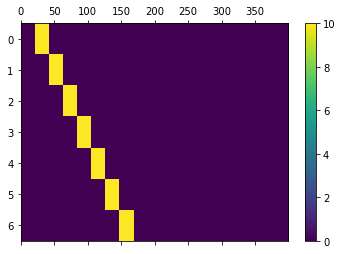

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_full.set(i, j, S_lacasa_full[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa_guaranteed = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_partial_guaranteed = Ncm.Matrix.new(S_lacasa_guaranteed.shape[0], S_lacasa_guaranteed.shape[1])
for i in range(len(S_lacasa_guaranteed)):
    for j in range(len(S_lacasa_guaranteed[i])):
        S_partial_guaranteed.set(i, j, S_lacasa_guaranteed[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa_maximal = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_partial_maximal = Ncm.Matrix.new(S_lacasa_maximal.shape[0], S_lacasa_maximal.shape[1])
for i in range(len(S_lacasa_maximal)):
    for j in range(len(S_lacasa_maximal[i])):
        S_partial_maximal.set(i, j, S_lacasa_maximal[i][j])

Full sky time (seconds) = 0.9255352020263672
Partial sky guaranteed time (seconds) = 45.20736789703369
Partial sky maximal time (seconds) = 26.290132761001587


# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])


ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 1423)
print(ncounts_gauss.get_fix_cov()) 

False


# Creating the fit object and calculating the MCMC

`Partial-Sky guaranteed`

In [9]:
print("Partial sky guaranteed")

mset_partial_guaranteed = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_partial_guaranteed)
ncounts_gauss.resample(mset_partial_guaranteed, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_partial_guaranteed))

mset_partial_guaranteed.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_guaranteed, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_partial_guaranteed)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_partial_guaranteed.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskyguaranteed_truth.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial sky guaranteed


y: 1329.701 3200.138 5187.581 6348.528 6853.023 7444.667 7077.009
0.82505858
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 4211835037.
# NcmMSetCatalog: Current mean:   76470        1.0298       0.26184     -0.99945      3.3214     
# NcmMSetCatalog: Current msd:    9641.3       0.01836      0.0004459    0.00045674   0.033825   
# NcmMSetCatalog: Current sd:     2.1559e+05   0.41055      0.0099707    0.010213     0.75636    
# NcmMSetCatalog: Current var:    4.6478e+10   0.16855      9.9415e-05   0.0001043    0.57207    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan      

In [10]:
ntests = 100.0
mcat = esmcmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_guaranteed.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

NameError: name 'fitmc' is not defined

`Full-Sky test guaranteed area`

In [11]:
print("Full Sky guaranteed area")

mset_full_guaranteed = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_full_guaranteed))

mset_full_guaranteed.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_full_guaranteed, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_full_guaranteed)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1

sampler = "apes"

nwalkers = int(math.ceil(250))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_full_guaranteed.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)

esmcmc.set_data_file("mcmc_fullsky_guaranteed_area_test.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky
y:       1329.70131491087       3200.13759592414       5187.58064494084       6348.52787525236       6853.02282018963       7444.66708996892       7077.00898861565
cov:        6685.94569002492      -287.094145007729      -123.095371467584      -39.3948931516009      -21.3956386782352      -5.29416677496461      -1.17342950367033
cov:       -287.094145007729       14081.2297219908      -893.229839801176      -301.023751806545      -94.7900990562832      -45.7593548090395      -19.8252451456431
cov:       -123.095371467584      -893.229839801176       20230.8868567175      -1504.83412245416      -489.338214896193      -152.809576373986      -68.2107575758649
cov:       -39.3948931516009      -301.023751806545      -1504.83412245416        23621.584257926      -1877.19016514536      -623.826213267404      -194.715800068564
cov:       -21.3956386782352      -94.7900990562832      -489.338214896193      -1877.19016514536       24154.7897707025      -1942.83863901625      -676.33686

In [ ]:
ntests = 100.0
mcat = esmcmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_full_guaranteed.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

`Partial Sky maximal`

In [12]:
print("Partial Sky maximal area")

mset_partial_maximal = mset.dup()
maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_partial_maximal)
ncounts_gauss.resample(mset_partial_maximal, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_partial_maximal))

mset_partial_maximal.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_maximal, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_partial_maximal)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_partial_maximal.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskymaximal_truth.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 4786.062 10590.085 17093.458 21660.502 24099.342 25298.605 23923.533
0.8282752832039165
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 3375773986.
# NcmMSetCatalog: Current mean:   3.9138e+05   1.0114       0.2506      -1.1065       3.2677     
# NcmMSetCatalog: Current msd:    50944        0.017723     0.00042917   0.00045187   0.033185   
# NcmMSetCatalog: Current sd:     1.1391e+06   0.39629      0.0095966    0.010104     0.74204    
# NcmMSetCatalog: Current var:    1.2976e+12   0.15705      9.2095e-05   0.00010209   0.55063    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfa

In [ ]:
ntests = 100.0
mcat = esmcmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_maximal.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

`Full-Sky test maximal area`

In [13]:
print("Full Sky")

mset_full_maximal = mset.dup()
maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_full_maximal))

mset_full_maximal.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_full_maximal, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_full_maximal)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1

sampler = "apes"

nwalkers = int(math.ceil(250))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_full_maximal.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)

esmcmc.set_data_file("mcmc_fullsky_maximal_area_test.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky
y:       4786.06172705875       10590.0849808158        17093.458489266       21660.5016851263       24099.3419684677       25298.6049496095       23923.5331885717
cov:        20745.0793750076        -2477.780435072      -888.083517918304      -328.980946591591       -171.33270187635      -74.6113723032782      -32.1655677718815
cov:         -2477.780435072       44294.0835836458       -5697.5774531772       -1901.2364194971      -691.648996367722      -338.019648022296      -168.823021935108
cov:       -888.083517918304       -5697.5774531772       65192.6247808674      -8429.09094412808      -2805.27332406206      -1004.60117013535      -471.111439658117
cov:       -328.980946591591       -1901.2364194971      -8429.09094412808       77601.2245432458      -9736.86719532213      -3320.93127319837      -1175.12768114074
cov:        -171.33270187635      -691.648996367722      -2805.27332406206      -9736.86719532213       80416.4617651729      -9554.20847661809       -3388.511

In [ ]:
ntests = 100.0
mcat = esmcmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_full_maximal.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)